# Metricas

***texto em itálico***

# Imports

In [ ]:
!pip install wtss[matplotlib]
!pip install geopandas
!pip install stac.py

     |████████████████████████████████| 308 kB 536 kB/s 
  Created wheel for wtss: filename=wtss-0.7.0.post3-py3-none-any.whl size=14670 sha256=47a6f5e37bc988903c71fe54631540affb3778af1b0a81684beb4cc2684f0998
  Stored in directory: /root/.cache/pip/wheels/0d/9d/66/801775accf40a08b29258802e11e970fe35731f750b91cd12e
Successfully built wtss
     |████████████████████████████████| 51 kB 170 kB/s 
  Created wheel for stac.py: filename=stac.py-0.9.0.post13-py3-none-any.whl size=49115 sha256=c03247e2df281ee1274f8988ca3c27724de6be050cf0e9b42a4c8bfb61f29ece
  Stored in directory: /root/.cache/pip/wheels/1c/c1/a6/29a677fd6928583dcf4e4ed2b75b5d9ecd076e1e1e9cd67083
Successfully built stac.py


In [ ]:
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from wtss import WTSS
from shapely.geometry import Point
from matplotlib.lines import Line2D
from scipy.signal import find_peaks

# Dados

In [ ]:
!wget -O MA_Agricultura.zip https://github.com/gabrielkoyama/MA-data/blob/main/MA_Agricultura.zip?raw=true

--2021-08-14 19:36:06--  https://github.com/gabrielkoyama/MA-data/blob/main/MA_Agricultura.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/gabrielkoyama/MA-data/raw/main/MA_Agricultura.zip [following]
--2021-08-14 19:36:06--  https://github.com/gabrielkoyama/MA-data/raw/main/MA_Agricultura.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gabrielkoyama/MA-data/main/MA_Agricultura.zip [following]
--2021-08-14 19:36:07--  https://raw.githubusercontent.com/gabrielkoyama/MA-data/main/MA_Agricultura.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request

In [ ]:
src_shape = './MA_Agricultura.zip'
if(src_shape.endswith(".zip")): src_shape = "zip://" + src_shape
gdf = gpd.read_file(src_shape)
gdf.head(3)

,Id,AreaHa,geometry
0,0,123.728289,"POLYGON ((-46.10101 -9.12546, -46.11679 -9.130..."
1,0,50.636272,"POLYGON ((-46.05035 -9.11305, -46.05314 -9.111..."
2,0,170.909537,"POLYGON ((-46.06614 -9.14071, -46.05112 -9.112..."


<AxesSubplot:>

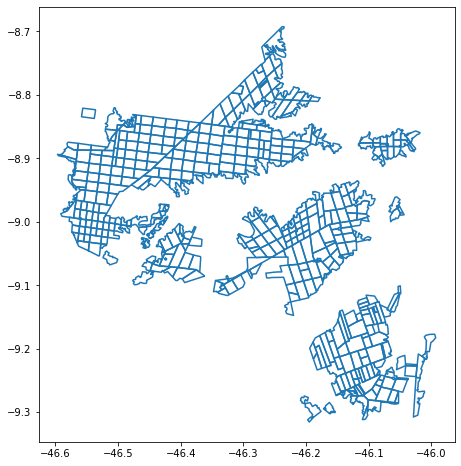

In [ ]:
gdf['geometry'].boundary.head(500).plot(figsize=(12,8))

In [ ]:
gdf["centroid"] = gdf.centroid

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


<AxesSubplot:>

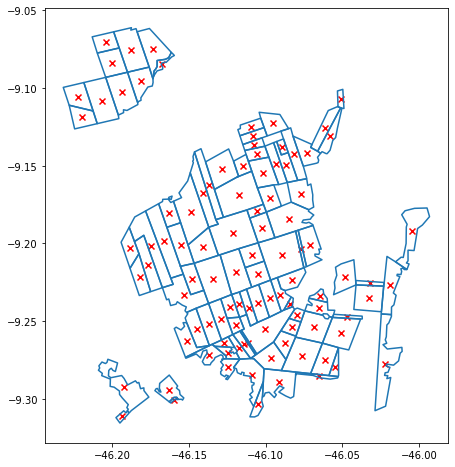

In [ ]:
ax = gdf['geometry'].boundary.head(100).plot(figsize=(12,8))
gdf["centroid"].head(100).plot(ax=ax, marker="x", color="red", figsize=(12,8))

<AxesSubplot:>

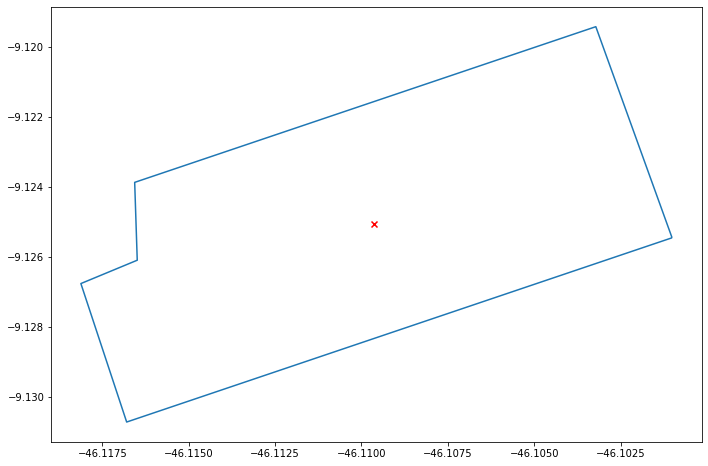

In [ ]:
ax = gdf['geometry'].boundary.head(1).plot(figsize=(12,8))
gdf["centroid"].head(1).plot(ax=ax, marker="x", color="red", figsize=(12,8))

**Set points**

---


In [ ]:
"""

0.0    POINT (-46.10963 -9.12506)
1.0    POINT (-46.10760 -9.12324)
2.0    POINT (-46.11397 -9.12813)
3.0    POINT (-46.10815 -9.12714)
4.0    POINT (-46.10315 -9.12348)
Name: centroid, dtype: geometry

"""

gdf.loc[1, "centroid"] = Point(-46.10963, -9.12506)
gdf.loc[2, "centroid"] = Point(-46.10760, -9.12324)
gdf.loc[3, "centroid"] = Point(-46.11397, -9.12813)
gdf.loc[4, "centroid"] = Point(-46.10815, -9.12714)
gdf.loc[5, "centroid"] = Point(-46.10315, -9.12348)



In [ ]:
minx, miny, maxx, maxy = gdf['geometry'].boundary.head(1).bounds.iloc[0]
gdf['geometry'].boundary.head(1).bounds

,minx,miny,maxx,maxy
0,-46.11812,-9.130727,-46.101009,-9.119429


**Random points**

---

In [ ]:
number_centroids = 5

for idx in range(0, number_centroids):
  x = random.uniform(maxx, minx)
  y = random.uniform(maxy, miny)
  gdf.loc[idx+1, "centroid"] = Point(x,y)
  # print(f'gdf.loc[{idx+1}, "centroid"] = Point({x},{y})')

In [ ]:
gdf["centroid"].head(5)

0    POINT (-46.10963 -9.12506)
1    POINT (-46.11036 -9.12251)
2    POINT (-46.10816 -9.12913)
3    POINT (-46.11017 -9.12704)
4    POINT (-46.11556 -9.12689)
Name: centroid, dtype: geometry

<AxesSubplot:>

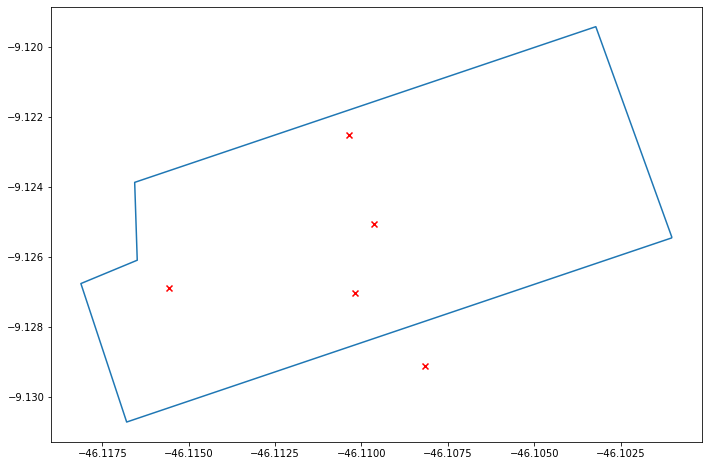

In [ ]:
ax = gdf['geometry'].boundary.head(1).plot(figsize=(12,8))
gdf["centroid"].head(5).plot(ax=ax, marker="x", color="red", figsize=(12,8))

# WTSS

**Sentinel stack 16D**

---

In [ ]:
service = WTSS('https://brazildatacube.dpi.inpe.br/', access_token='mO0YnCebwFIBd9dijD4JgNMG1sp2NPLOZ6MKE9m65h')
coverage = service['S2-recent_10_16D_STK-1']
coverage

name,common name,description,datatype,valid range,scale,nodata
B01,B01,,uint16,"{'min': 0.0, 'max': 10000.0}",0.0001,0.0
B02,B02,,uint16,"{'min': 0.0, 'max': 10000.0}",0.0001,0.0
NDVI,NDVI,,int16,"{'min': 0.0, 'max': 10000.0}",0.0001,-9999.0
EVI,EVI,,int16,"{'min': 0.0, 'max': 10000.0}",0.0001,-9999.0
CLEAROB,ClearOb,Clear Observation Count.,uint8,"{'min': 0.0, 'max': 255.0}",1.0,0.0
TOTALOB,TotalOb,Total Observation Count,uint8,"{'min': 0.0, 'max': 255.0}",1.0,0.0
PROVENANCE,Provenance,Provenance value Day of Year,int16,"{'min': 1.0, 'max': 366.0}",1.0,-1.0
B03,B03,,uint16,"{'min': 0.0, 'max': 10000.0}",0.0001,0.0
B04,B04,,uint16,"{'min': 0.0, 'max': 10000.0}",0.0001,0.0
B05,B05,,uint16,"{'min': 0.0, 'max': 10000.0}",0.0001,0.0


**Get time-series from points**

---

In [ ]:
for idx, row in gdf.iloc[:5].iterrows():
  print(row.centroid)

POINT (-46.10962563452907 -9.125058923157708)
POINT (-46.11035701115519 -9.122510404285084)
POINT (-46.10815729244223 -9.129132953351787)
POINT (-46.11017312067997 -9.127036080105157)
POINT (-46.1155567797887 -9.126885870276736)


In [ ]:
sentinel_ts = []
for idx, row in gdf.iloc[:5].iterrows():
  lat = float(round(row.centroid.y, 3))
  lng = float(round(row.centroid.x, 3))

  ts = coverage.ts(attributes=('NDVI'),
                 latitude=lat, 
                 longitude=lng)
  
  sentinel_ts.append({"values":ts.values("NDVI"), "timeline": ts.timeline})
  print(f"{int(idx+1)}/{5} - Latitude: {lat}, Longitude: {lng} - ok")

1/5 - Latitude: -9.125, Longitude: -46.11 - ok
2/5 - Latitude: -9.123, Longitude: -46.11 - ok
3/5 - Latitude: -9.129, Longitude: -46.108 - ok
4/5 - Latitude: -9.127, Longitude: -46.11 - ok
5/5 - Latitude: -9.127, Longitude: -46.116 - ok


**Creating Dataframe**

---

In [ ]:
df_sentinel = pd.DataFrame()

for i, sts in enumerate(sentinel_ts):
  df_aux = pd.DataFrame()
  df_aux["values"]      = sts["values"]
  df_aux["timeline"]    = sts["timeline"]
  df_aux["point_idx"]   = i
  df_aux["satelite"]    = ts.get("query")["coverage"]
  df_sentinel = df_sentinel.append(df_aux)

    
df_sentinel.head(10)

,values,timeline,point_idx,satelite
0,-648.0,2019-01-01T00:00:00,0,S2-recent_10_16D_STK-1
1,7441.0,2019-01-17T00:00:00,0,S2-recent_10_16D_STK-1
2,4400.0,2019-02-02T00:00:00,0,S2-recent_10_16D_STK-1
3,6508.0,2019-02-18T00:00:00,0,S2-recent_10_16D_STK-1
4,2126.0,2019-03-06T00:00:00,0,S2-recent_10_16D_STK-1
5,1694.0,2019-03-22T00:00:00,0,S2-recent_10_16D_STK-1
6,808.0,2019-04-07T00:00:00,0,S2-recent_10_16D_STK-1
7,2723.0,2019-04-23T00:00:00,0,S2-recent_10_16D_STK-1
8,3010.0,2019-05-09T00:00:00,0,S2-recent_10_16D_STK-1
9,2411.0,2019-05-25T00:00:00,0,S2-recent_10_16D_STK-1


**Median of points**

---

In [ ]:
df_median = df_sentinel.copy()
values = []
for point_idx in np.unique(df_median["point_idx"]):
  values.append(df_median.groupby("point_idx").get_group(point_idx)["values"])

median = np.median(values, axis=0)

**Transform date type**

---

In [ ]:
df_sentinel.timeline = pd.to_datetime(df_sentinel.timeline)
df_sentinel.timeline = df_sentinel.timeline.dt.strftime('%Y-%m-%d')

**Plot data**

---


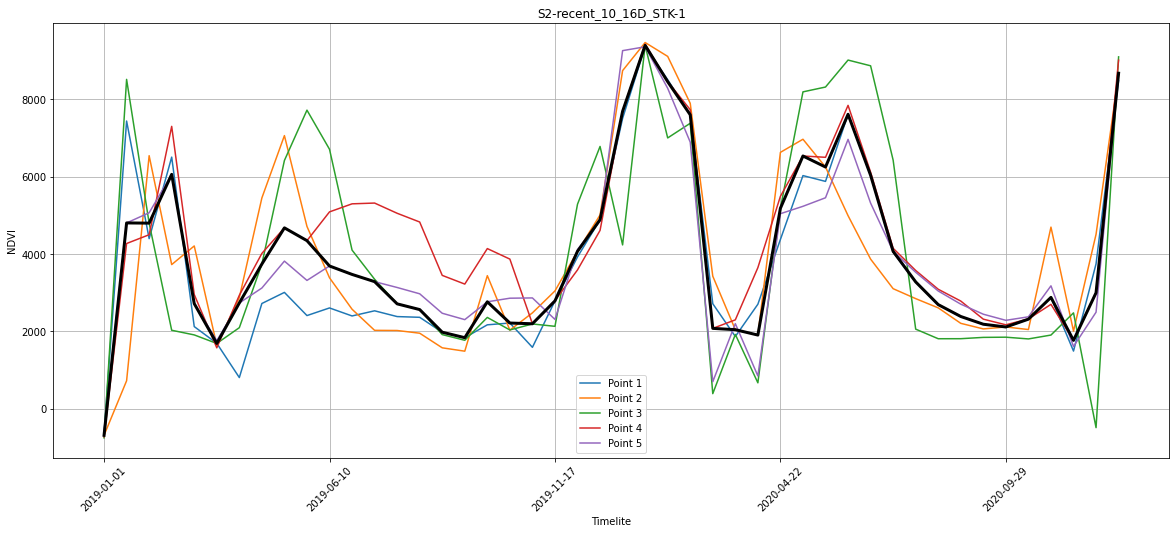

In [ ]:
df = df_sentinel.copy()

fig, ax = plt.subplots(figsize=(20,8))
for name, group in df.groupby('point_idx'):
  name = "Point " + str(name+1)
  group.plot('timeline', y='values', ax=ax, label=name)

plt.legend()
plt.grid(True)
plt.xlabel('Timelite')
plt.ylabel('NDVI')
plt.title("S2-recent_10_16D_STK-1")
plt.xticks(rotation=45)

plt.plot(median, color="black", linewidth=3)

plt.show()


**Filtering by date**

---

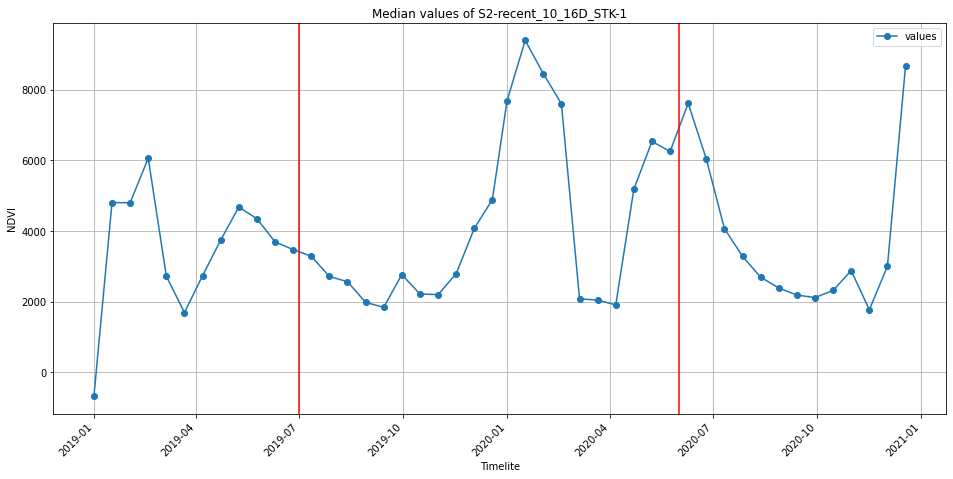

In [ ]:
start_date='2019-07-01'
end_date='2020-06-01'

df = pd.DataFrame()
df["timeline"] = df_sentinel.groupby("point_idx").get_group(0)["timeline"]
df["values"]   = median

df["timeline"] = df["timeline"].apply(pd.Timestamp)
df = df.set_index("timeline")

df.plot(marker='o', figsize=(16,8))

plt.axvline(pd.Timestamp(start_date), color='r')
plt.axvline(pd.Timestamp(end_date), color='r')

plt.legend()
plt.grid(True)
plt.xlabel('Timelite')
plt.ylabel('NDVI')
plt.title("Median values of S2-recent_10_16D_STK-1")
plt.xticks(rotation=45)

plt.show()

In [ ]:
df = df[(df.index >= start_date) & (df.index <= end_date)]

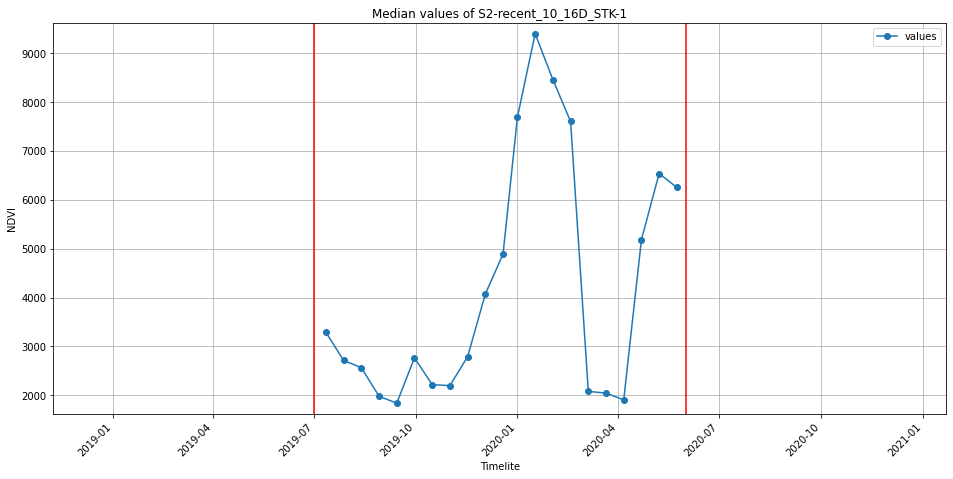

In [ ]:
df.plot(marker='o', figsize=(16,8))

plt.axvline(pd.Timestamp(start_date), color='r')
plt.axvline(pd.Timestamp(end_date), color='r')

plt.legend()
plt.grid(True)
plt.xlabel('Timelite')
plt.ylabel('NDVI')
plt.title("Median values of S2-recent_10_16D_STK-1")
plt.xticks(rotation=45)

plt.margins(0.7, 0.03)

plt.show()

# **Suavização**

---

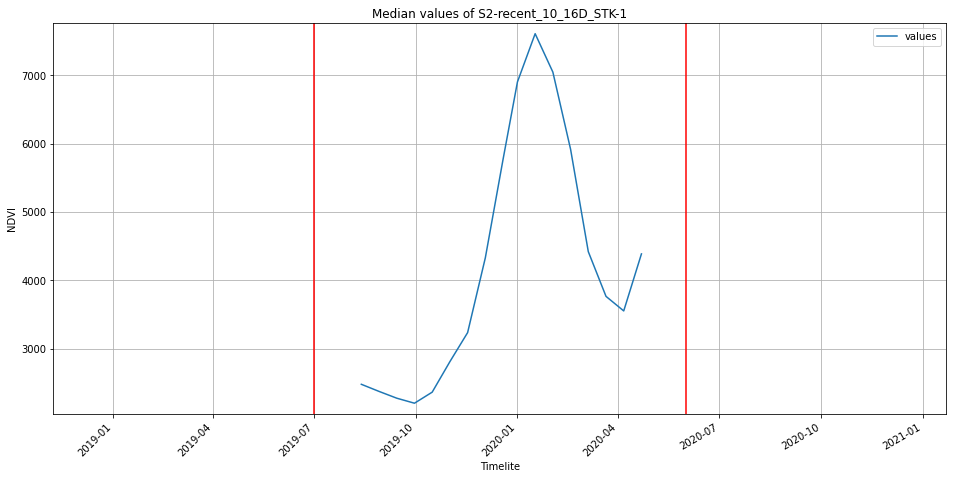

In [ ]:
df_suave = df.copy()
df_suave = df_suave.rolling(5).mean().shift(-2)

df_suave.plot(figsize=(16,8))

plt.axvline(pd.Timestamp(start_date), color='r')
plt.axvline(pd.Timestamp(end_date), color='r')

plt.legend()
plt.grid(True)
plt.xlabel('Timelite')
plt.ylabel('NDVI')
plt.title("Median values of S2-recent_10_16D_STK-1")
plt.xticks(rotation=45)

plt.margins(0.7, 0.03)

plt.show()

# **Planting and harvesting estimate**

---

## **Slope**

In [ ]:
def find_slope(df):
    y = np.array(df['values'].values)
    x = np.array(list(range(0, len(y))))
    
    # calculate slope
    slope_y = (y[1:] - y[:-1])/(x[1]-x[0])
    
    # Get sign
    slope_ys = np.sign(slope_y)
    
    # number of maximus and minimus
    slope_qt = ((slope_ys[:-1] + slope_ys[1:]) == 0).sum()
    print(f"Number of maximus and minimus: {slope_qt}")
    
    ms = (slope_ys[:-1] + slope_ys[1:]) == 0
    
    # insert False
    ms = np.insert(ms, [False], 0)
    
    # append
    ms = np.append(ms, [False])

    return ms, y, x



Number of maximus and minimus: 3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer


[]

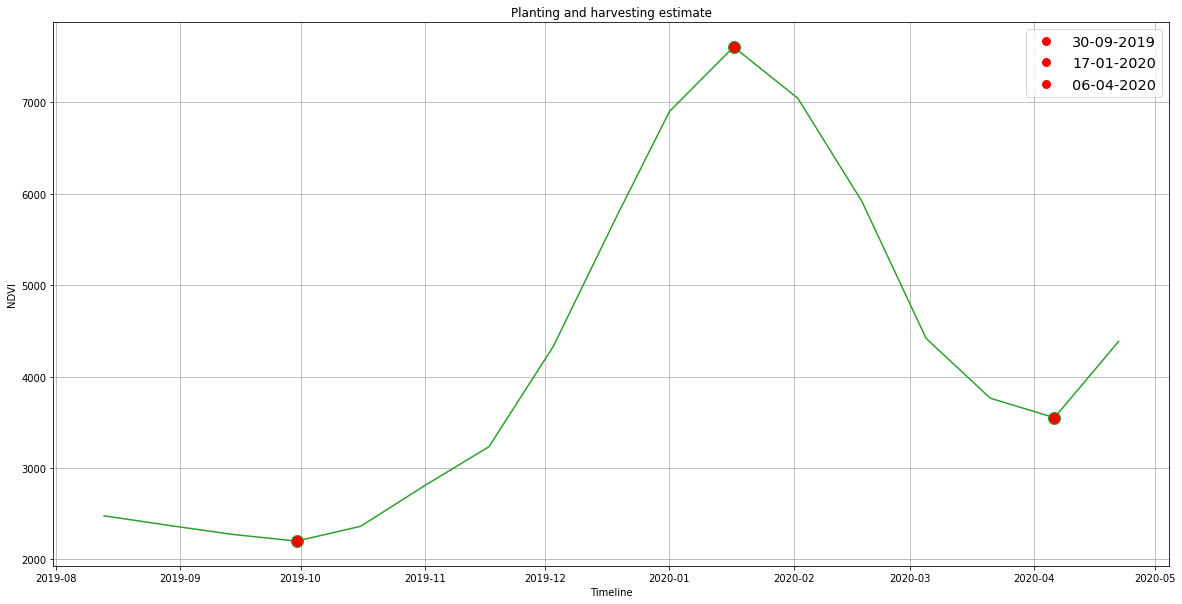

In [ ]:
m, y, x = find_slope(df_suave)

df_suave.reset_index(inplace=True)

predicted_dates = []
for d in df_suave.timeline[m].values:
    predicted_dates.append(pd.to_datetime(str(d)).strftime("%d-%m-%Y"))

marker = x[m]
legend_marker = Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor='r', markersize=10)
custom_lines = [legend_marker for x in range(0, len(marker))]

xs = df_suave.timeline.values
ys = df_suave['values'].values

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(xs, ys, '-o', markevery=marker, markerfacecolor='red', markersize=12, color="tab:green")
ax.legend(custom_lines, predicted_dates, fontsize = 'x-large')

plt.xlabel("Timeline")
plt.ylabel("NDVI")
plt.title("Planting and harvesting estimate")
plt.grid(True)
plt.plot()

Number of maximus and minimus: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer


[]

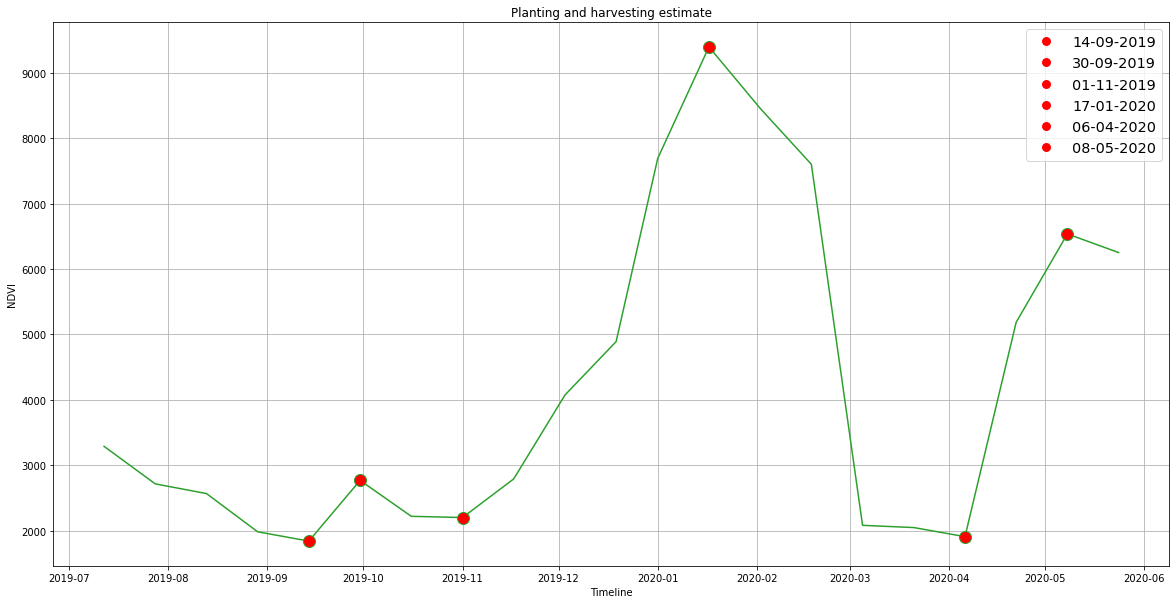

In [ ]:
df_t = df.copy()

df_t.reset_index(inplace=True)

m, y, x = find_slope(df_t)

predicted_dates = []
for d in df_t.timeline[m].values:
    predicted_dates.append(pd.to_datetime(str(d)).strftime("%d-%m-%Y"))

marker = x[m]
legend_marker = Line2D([0], [0], marker='o', color='w', label='Scatter',markerfacecolor='r', markersize=10)
custom_lines = [legend_marker for x in range(0, len(marker))]

xs = df_t.timeline.values
ys = df_t['values'].values

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(xs, ys, '-o', markevery=marker, markerfacecolor='red', markersize=12, color="tab:green")
ax.legend(custom_lines, predicted_dates, fontsize = 'x-large')

plt.xlabel("Timeline")
plt.ylabel("NDVI")
plt.title("Planting and harvesting estimate")
plt.grid(True)
plt.plot()

**find_peaks scipy test**

---

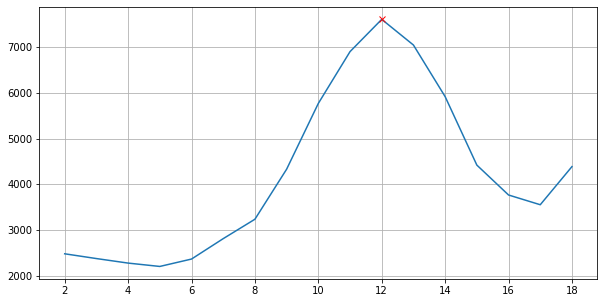

In [ ]:
y = np.array(df_suave['values'].values)
x = np.array(range(0, len(y)))

peaks, _ = find_peaks(y, distance=1)

fig = plt.figure(figsize=(10,5))
plt.grid()
plt.plot(y)
plt.plot(peaks, y[peaks], 'x', color="red")
plt.show()

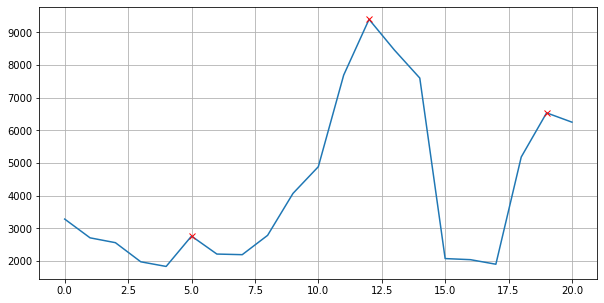

In [ ]:
y = np.array(df['values'].values)
x = np.array(range(0, len(y)))

peaks, _ = find_peaks(y, distance=1)

fig = plt.figure(figsize=(10,5))
plt.grid()
plt.plot(y)
plt.plot(peaks, y[peaks], 'x', color="red")
plt.show()

**find_peaks_cwt scipy test**

---

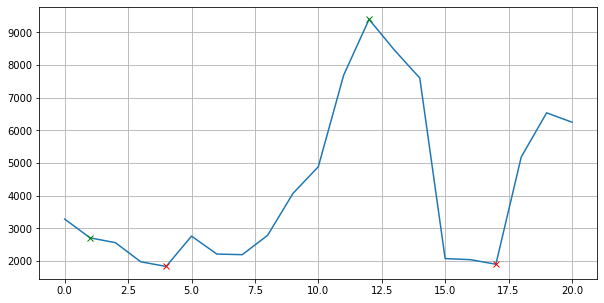

In [ ]:
# xs = np.linspace(-np.pi, np.pi, 30)
# ys = np.sin(xs)

from scipy import signal

y = np.array(df['values'].values)
x = np.array(range(0, len(y)))

max_peakind = signal.find_peaks_cwt(y, np.arange(1,10))
inv_data = 1/y

min_peakind = signal.find_peaks_cwt(inv_data, np.arange(1,10))

fig = plt.figure(figsize=(10,5))
plt.grid()
plt.plot(y)
plt.plot(max_peakind, y[max_peakind], "x", color="green")
plt.plot(min_peakind, y[min_peakind], "x", color="red")
plt.show()

# **Images from date**

--- 

- STAC Search from images from this dates

# Metrics